# Load Libraries

In [1]:
library(timeDate)
library(timeSeries)
library(zoo)
library(fBasics)
library(lmtest)
library(tseries)
library(forecast)
library(reshape2)


Attaching package: ‘zoo’

The following object is masked from ‘package:timeSeries’:

    time<-

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



# Preparation: GDP

In [2]:
# Load GDP data (note that data is transposed, so header=FALSE)
gdp <- read.table("raw_data/GDP.csv", header=FALSE, sep=",")

In [3]:
# Transpose data
gdp <- as.data.frame(t(gdp))
# Make first row the column names
colnames(gdp) <- as.character(unlist(gdp[1,]))
# Remove the first row from data
gdp <- gdp[-1, ]

In [4]:
# Keep only needed columns
df <- gdp[,c("Year", "Gross domestic product")]
# Rename columns for easier access
colnames(df) <- c("Year","GDP")

In [5]:
# Note here that our data are consider factors at this point. This is actually
# because our data got imported with commas, making R think that the numeric
# data are character values
sapply(df, class)

Year      GDP 
"factor" "factor"

In [6]:
# Here we remove commas with gsub, apply over all columns except for year.
# the as.numeric function converts into numeric format
df[,-1] <- as.numeric(gsub(",", "", as.matrix(df[,-1])))

In [7]:
head(df)

,Year,GDP
V2,1929,104560
V3,1930,92167
V4,1931,77406
V5,1932,59532
V6,1933,57165
V7,1934,66812


# Preparation: Unemployment

In [8]:
# Read data (note that data is monthly at this point)
unemployment <- read.table("raw_data/unemployment.csv", header=TRUE, sep=",")

In [9]:
# We will roll-up monthly data by taking mean for the year
# Keep first column separate ("Year"), and take rowMeans of rest
unemployment <- data.frame(Year=unemployment[,1], Unemployment=rowMeans(unemployment[,-1]))

In [10]:
# Merge GDP and unemployment data together
# Note that here we are dropping years 1929 - 1947, which do not appear in
# unemployment data. This is an intentional omission to avoid issues with
# attempting to understand politics in the non-modern era. By setting
# our focus to post-WWII, we hope to make better sense of modern trends.
df <- merge(df, unemployment, by="Year", sort = TRUE)

In [11]:
head(df)

Year,GDP,Unemployment
1948,274807,3.750000
1949,272827,6.050000
1950,300198,5.208333
1951,347294,3.283333
1952,367728,3.025000
1953,389739,2.925000


# Preparation: Congress

In [12]:
congress <- read.table('raw_data/political_parties.csv', header=TRUE, sep=",")

In [13]:
# Reshape the data from long to wide format
wide <- dcast(congress, Congress + Years + Chamber ~ PartyStatus, value.var='Seats')

In [14]:
head(wide)

Congress,Years,Chamber,All,Democrat,Other,Republican,Vacant
34,1855 - 1857,House,234,83,43,108,.
34,1855 - 1857,Senate,62,42,5,15,.
35,1857 - 1859,House,237,131,14,92,.
35,1857 - 1859,Senate,64,39,5,20,.
36,1859 - 1861,House,237,101,23,113,.
36,1859 - 1861,Senate,66,38,2,26,.


In [15]:
# Split into house and senate frames
house <- wide[wide$Chamber == 'House', ]
senate <- wide[wide$Chamber == 'Senate', ]

In [16]:
# Define functions to help us grab the odd and even indices
odd <- function(x) x%%2 != 0
even <- function(x) x%%2 == 0

In [17]:
# Define function to subtract 1 from a char(Year)
sub_one <- function(x) as.character(as.numeric(x) - 1)

In [18]:
# Define function to transform frame into year-by-year
transform_congress <- function (df) {
    # Ensure congressional numbers are numeric
    df$Republican <- as.numeric(df$Republican)
    df$Democrat <- as.numeric(df$Democrat)
    # Create new column for difference
    df$R_diff <- df$Republican - df$Democrat
    # Split Years into first and second year
    s <- strsplit(as.character(df$Years), split = " - ")
    # Gather odd and even indices
    odds = odd(1: length(s))
    evens = even(1: length(s))
    # For odd indices, leave as is. For even indices, subtract one from year
    new_years <- append(unlist(s)[odds], lapply(unlist(s)[evens], sub_one))
    # Duplicate each row in df
    df <- df[rep(1:nrow(df),each=2),] 
    # Put new_years into the df
    df$Year <- sort(unlist(new_years))
    # Drop unneeded columns
    keeps <- c("Year", "R_diff")
    df <- df[keeps]
    # Reset row names
    rownames(df) <- seq(length=nrow(df))
    return(df)
}

In [19]:
# Transform house and senate
house <- transform_congress(house)
senate <- transform_congress(senate)
# Merge data together
congress <- merge(house, senate, by="Year", sort = TRUE, suffixes=c("_house", "_senate"))

In [20]:
head(congress)

Year,R_diff_house,R_diff_senate
1855,25,-27
1856,25,-27
1857,-39,-19
1858,-39,-19
1859,12,-12
1860,12,-12


# Merge all together

In [21]:
# Merge data together
df <- merge(df, congress, by="Year", sort = TRUE)

In [22]:
head(df)

Year,GDP,Unemployment,R_diff_house,R_diff_senate
1948,274807,3.750000,58,6
1949,272827,6.050000,-92,-12
1950,300198,5.208333,-92,-12
1951,347294,3.283333,-35,-1
1952,367728,3.025000,-35,-1
1953,389739,2.925000,8,2


# Explore Data

In [23]:
# Set plot size
options(repr.plot.width=12, repr.plot.height=8)

In [24]:
# Convert to time series
gdp = ts(df$GDP, start=c(1948,2), freq=1)
emp = ts(df$Unemployment, start=c(1948,2), freq=1)
R_hs = ts(df$R_diff_house, start=c(1948,2), freq=1)
R_sn = ts(df$R_diff_senate, start=c(1948,2), freq=1)

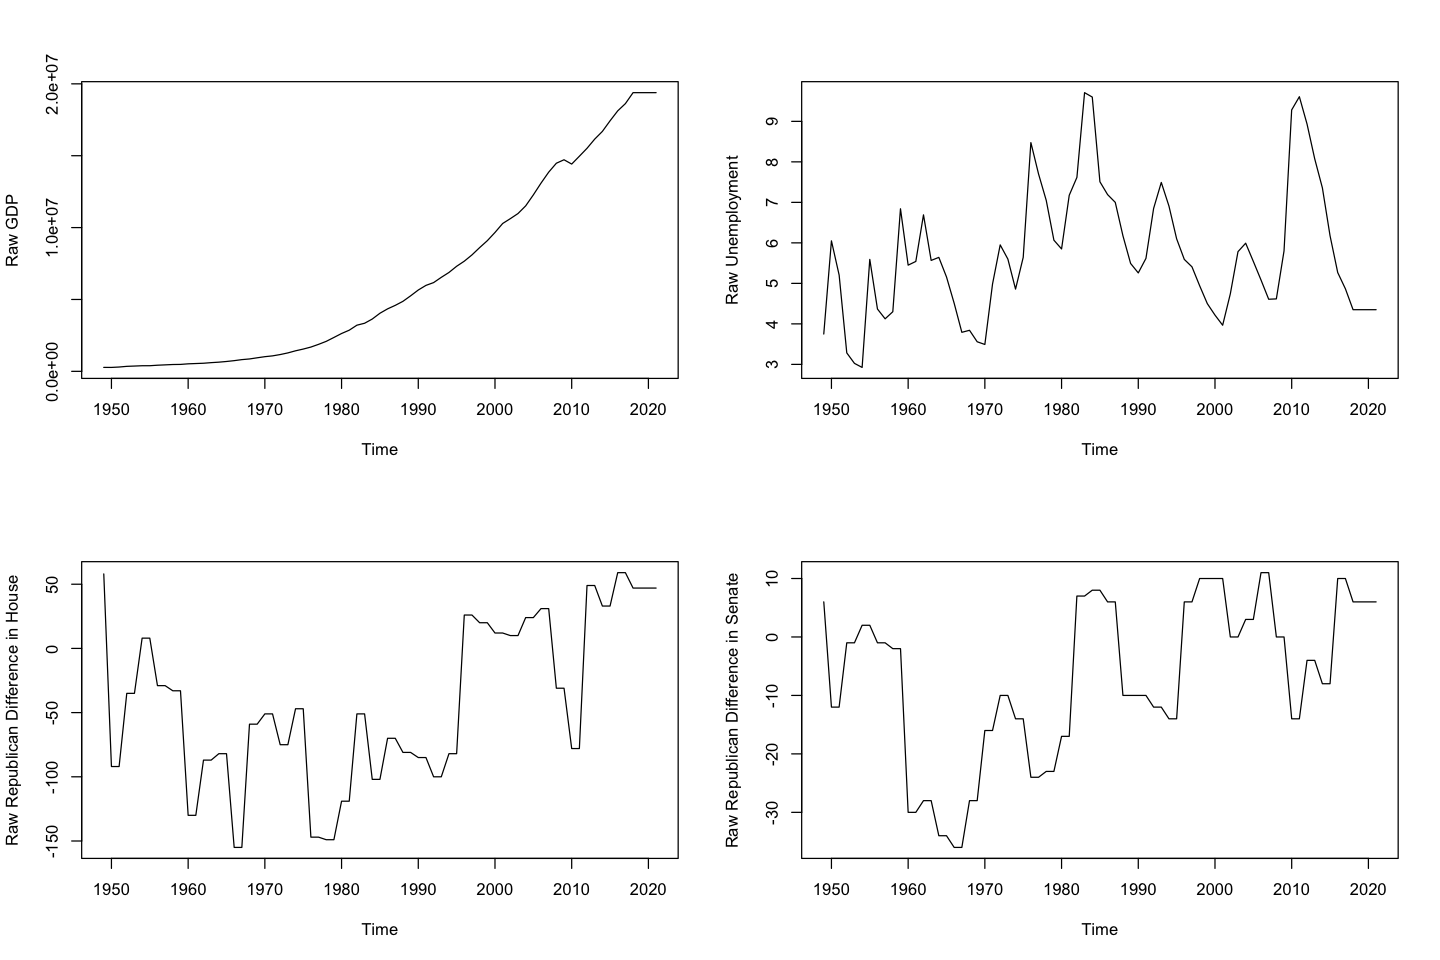

In [25]:
# Plot Time Series of Raw Data
par(mfrow=c(2,2))
plot(gdp, ylab='Raw GDP')
plot(emp, ylab='Raw Unemployment')
plot(R_hs, ylab='Raw Republican Difference in House')
plot(R_sn, ylab='Raw Republican Difference in Senate')

# Output Data

In [26]:
write.csv(file='cleaned_data.csv', x=df)